# Exploring biologically relevant clusters in Census embeddings

In this notebook, we explore biologically relevant clusters in Census embeddings using UMAP as a visualization tool. This demonstration assumes knowledge of how to access both maintained and hosted (community) Census embeddings. To learn the basics on accessing these data please visit the [Census model page](https://cellxgene.cziscience.com/census-models).

The journey from a gene expression matrix to a 2D scatterplot involves numerous highly nonlinear transformations. Such transformations can introduce artifacts that affect both the global and local structures in the visualized manifold. 

Common issues like overclustering and clustering by batch are typical artifacts resulting from these dimensionality reduction methods. With that in mind, these embeddings and their UMAP visualizations are best used as tools for generating hypotheses. They should not be the final word in analysis. Instead, we recommend focusing on the full representation of the embedding matrices and ultimately returning to the underlying gene expressions to investigate the reasons behind the observed clustering patterns.

One of the key objectives of foundation models in single-cell RNA sequencing is to embed cells within a universal coordinate system that minimizes the impact of technical variations, such as batch effects. However, as we will see in the examples presented in this notebook, cells often cluster by batch. This clustering could be biologically driven, as certain cell types or states might be unique to specific batches (e.g. datasets). In other cases, the separation might be purely due to systematic technical biases, or a combination of both biological and technical factors. Complicating the matter, the techniques used for nearest neighbor graph construction and 2D projection can themselves amplify batch effects. Rigorous benchmarking is necessary to fully assess each model's capability in integrating data within their respective latent spaces. This complexity highlights that data integration in single-cell RNA sequencing remains a challenging and unsolved problem. 

In this tutorial, we briefly highlight a few simple case studies that illustrate the capacity of these embeddings to capture intriguing biological phenomena.

**Disclaimers** 

1. These embeddings were explored in-depth in a [cellxgene](https://github.com/chanzuckerberg/cellxgene) instance and not all of the insights gleaned there will be expanded on here.
2. Most of the following examples utilize UMAP to visualize embeddings in a 2D scatter plot, however as shown [here](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011288) and [here](https://www.cell.com/cell-systems/pdf/S2405-4712(23)00209-0.pdf), biological interpretations from these visualizations may be innacurate.

**Contents**

1. Requirements
1. Imports and function definitions
1. Melanocytes in eye
1. Retinal bipolar neurons in eye
1. Dopaminergic neurons in brain
1. Pulmonary ionocytes in lung

>⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable is_primary_data which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Requirements
 - CELLxGENE Census (>=1.9.1)
 - scanpy
 - numpy
 - scipy
 - leidenalg
 - hdbscan
 - pandas
 - scikit-learn

## Imports and function definitions

In [1]:
import json
import cellxgene_census
import anndata
import numpy as np
import scanpy as sc
import warnings
import tiledbsoma as soma
from scipy import sparse
from typing import List
from cellxgene_census.experimental import get_embedding, get_embedding_metadata
warnings.filterwarnings('ignore')

def generate_umaps_from_embeddings(adata: anndata.AnnData, emb_names: list, metric="euclidean"):
    """
    Generate UMAPs from embeddings stored in `adata.obsm`.
    `emb_names` is a list that contains keys present in `adata.obsm`.
    """

    adata = adata.copy()
    for emb_name in emb_names:
        print(f"Generating UMAP for {emb_name}")
        sc.pp.neighbors(adata, n_neighbors=15, use_rep=emb_name, method="umap", key_added=emb_name, metric=metric)
        sc.tl.umap(adata, neighbors_key=emb_name)
        X_emb_name = emb_name if emb_name[:2] == "X_" else f"X_{emb_name}"
        if metric != "euclidean":
            X_emb_name += f"_{metric}"
        adata.obsm[f"{X_emb_name}_umap"] = adata.obsm["X_umap"]
        del adata.obsm["X_umap"]

    adata.var_names = adata.var["feature_name"]
    adata.raw = adata.copy()
    sc.pp.normalize_total(adata, target_sum=10000)
    sc.pp.log1p(adata)

    return adata


def build_anndata_with_embeddings(
    embedding_uris: dict, 
    embedding_names: List[str], 
    coords: List[int] = None,
    obs_value_filter: str = None,
    census_version: str = None, 
    experiment_name: str = None,
):
    """
    For a given set of Census cell coordinates (soma_joinids) 
    fetch embeddings with TileDBSoma and return the corresponding
    AnnData with embeddings slotted in.

    `embedding_uris` is a dict with community embedding names as the keys and S3 URI as the values.
    `embedding_names` is a list with embedding names included in Census.


    Assume that all embeddings provided are coming from the same experiment.
    """
    
    with cellxgene_census.open_soma(census_version=census_version) as census:

        print("Getting anndata with Census embeddings: ", embedding_names)
        
        ad = cellxgene_census.get_anndata(
            census,
            organism = experiment_name,
            measurement_name = "RNA",
            obs_value_filter = obs_value_filter,
            obs_coords = coords,
            obsm_layers = embedding_names
        )
        
        for key in embedding_uris:
            print("Getting community embedding:", key)
            embedding_uri = embedding_uris[key]
            ad.obsm[key] = get_embedding(
                census_version, 
                embedding_uri, 
                ad.obs["soma_joinid"].to_numpy()
            )
    
    # Embeddings with missing data contain all NaN,
    # so we must find the intersection of nonzero rows in the fetched embeddings
    # and subset the AnnData accordingly.
    filt = np.ones(ad.shape[0], dtype="bool")
    for key in ad.obsm.keys():
        nan_row_sums = np.sum(np.isnan(ad.obsm[key]), axis=1)
        total_columns = ad.obsm[key].shape[1]
        filt = filt & (nan_row_sums != total_columns)
    ad = ad[filt].copy()

    return ad

In [2]:
# human embeddings
CENSUS_VERSION = "2023-12-15"
EXPERIMENT_NAME = "homo_sapiens"

# These are embeddings contributed by the community hosted in S3
embedding_uris_community = {
    "scgpt": f"s3://cellxgene-contrib-public/contrib/cell-census/soma/{CENSUS_VERSION}/CxG-contrib-1/",
    "uce": f"s3://cellxgene-contrib-public/contrib/cell-census/soma/{CENSUS_VERSION}/CxG-contrib-2/",
}

# These are embeddings included in the Census data
embedding_names_census = ["geneformer", "scvi"]

# All embedding names
embedding_names_all = embedding_names_census + list(embedding_uris_community.keys())

## Melanocytes in eye

### Sample and fetch 150k cells from eye tissue

In [3]:
census = cellxgene_census.open_soma(census_version=CENSUS_VERSION)

# Let's find our cells of interest
obs_value_filter = "tissue_general=='eye' and is_primary_data == True"

obs_df = census["census_data"][EXPERIMENT_NAME].obs.read(
    value_filter = obs_value_filter,
    column_names = ["soma_joinid"]
)

obs_df = obs_df.concat().to_pandas() 
print(obs_df.shape[0], "cells in", obs_value_filter)

# Let's subset to 150K
n_subset_cells = 150000
print("Selecting ", n_subset_cells, " random cells")
idx_rand = np.random.choice(obs_df.shape[0], size=n_subset_cells, replace=False)
soma_joinids_subset = obs_df["soma_joinid"].values[idx_rand].tolist()

# Let's get the AnnData
adata = build_anndata_with_embeddings(
    embedding_uris_community, 
    embedding_names_census,
    coords=soma_joinids_subset,
    experiment_name=EXPERIMENT_NAME, 
    census_version=CENSUS_VERSION,
)

adata = generate_umaps_from_embeddings(adata, embedding_names_all)

799353 cells in tissue_general=='eye' and is_primary_data == True
Selecting  150000  random cells
Getting anndata with Census embeddings:  ['geneformer', 'scvi']
Getting community embedding: scgpt
Getting community embedding: uce
Generating UMAP for geneformer
Generating UMAP for scvi
Generating UMAP for scgpt
Generating UMAP for uce


### Observations

In the study of melanocytes within the eye, the following observations are made across various embeddings:

 - Melanocytes are distinctly clustered in all embeddings, with OCA2 as a noted marker.
 - KIT, [identified as a marker for mature melanocytes](https://iovs.arvojournals.org/article.aspx?articleid=2743921), shows varying degrees of separation. In SCVI and UCE embeddings, mature and immature melanocytes are clearly separable based on KIT expression. The scGPT embedding shows a slight extension from the main melanocyte cluster, indicative of some separation, where KIT expression is concentrated. In Geneformer, cells expressing KIT are primarily found at one end of the larger melanocyte cluster.
 - When applying UMAP to the UCE embedding, the global structure does not seem to be preserved. For example, the mature and immature melanocytes are far from each other, whereas they are co-localized in the other embeddings.
 - The UCE embedding demonstrates potential signs of overclustering. An example is seen in retinal bipolar neurons, which separate into numerous small satellite clusters without clear gene expression signatures. The high degree of local structure in the UCE manifold is probably due to the presence of many disconnected components in the graph constructed by UMAP. This corroborates the previous observation that global structure is not preserved.
 - Across all embeddings, assays tend to cluster separately. The extent to which this reflects biological variability versus technical variation is unclear.
 - Qualitatively, SCVI appears to offer the best integration across different datasets, with other embeddings showing more pronounced clustering by dataset.
 

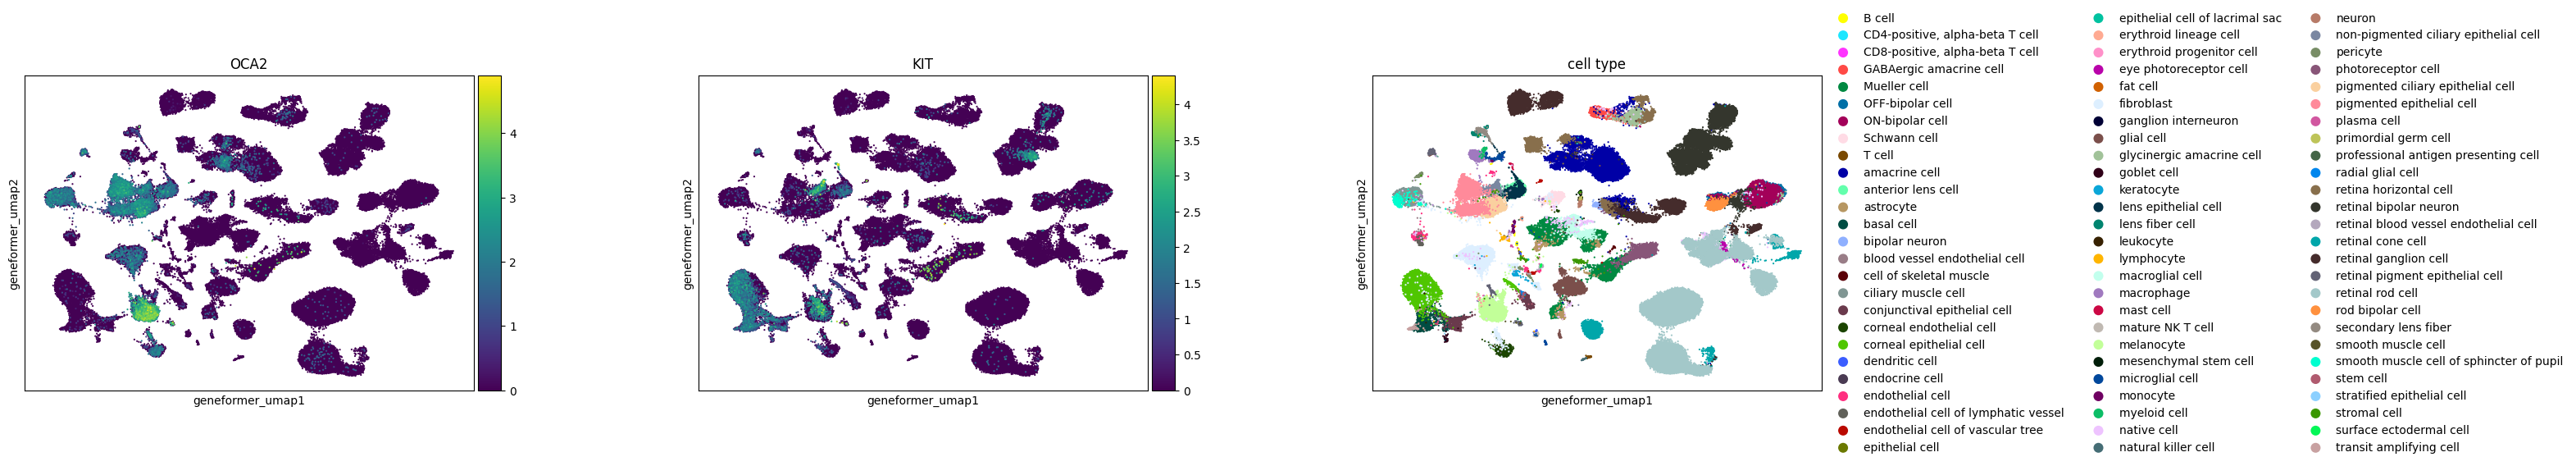

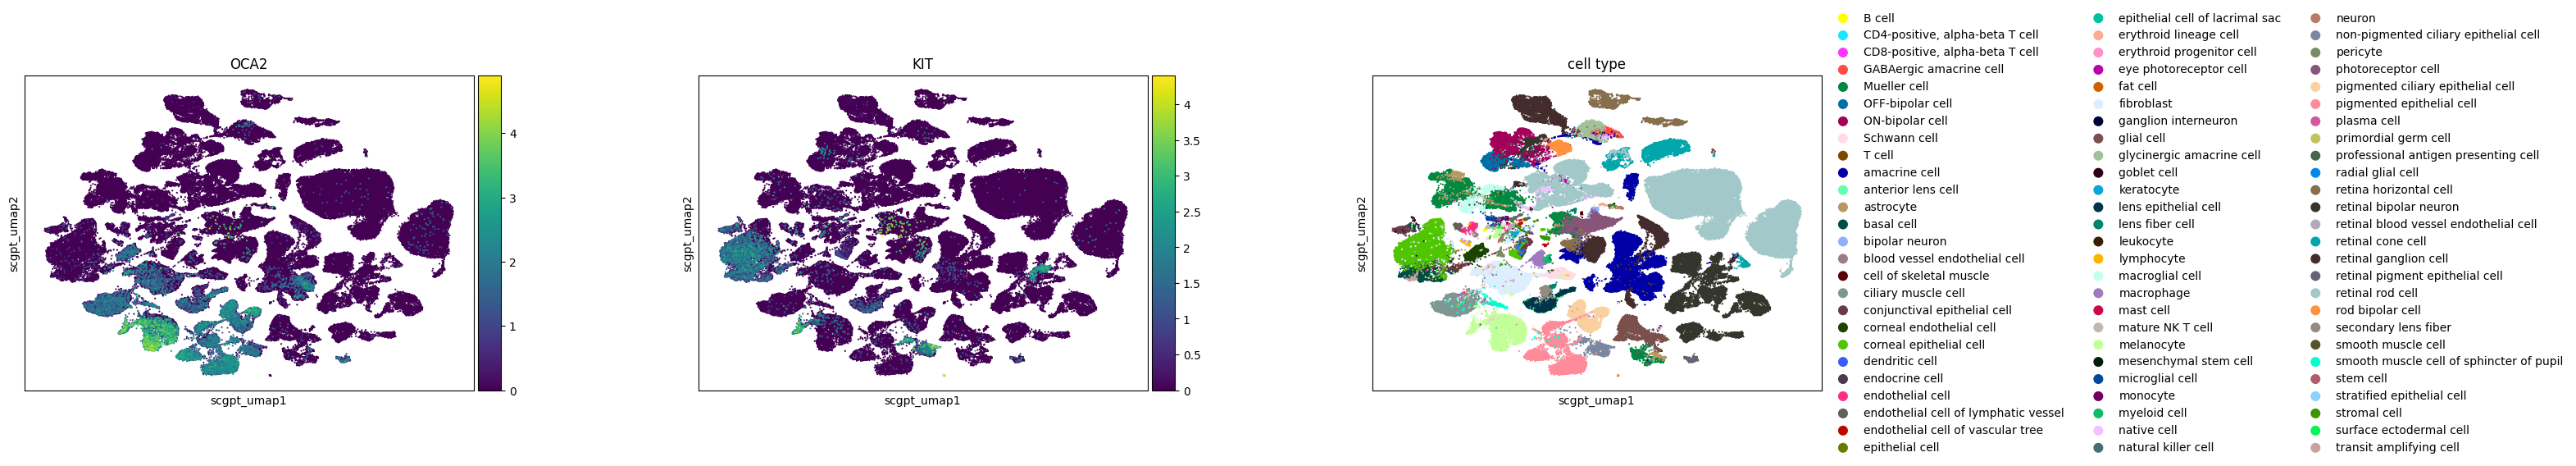

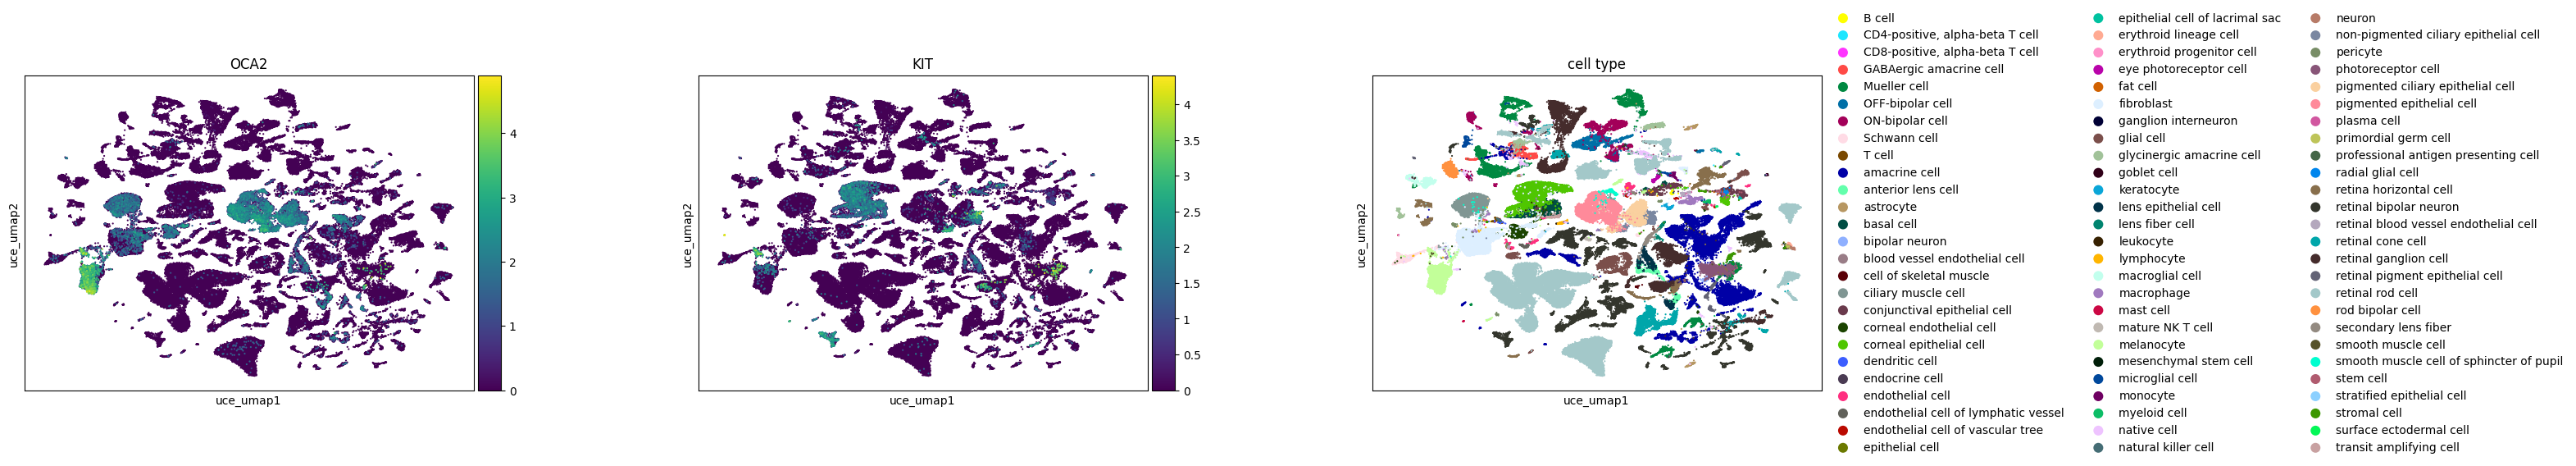

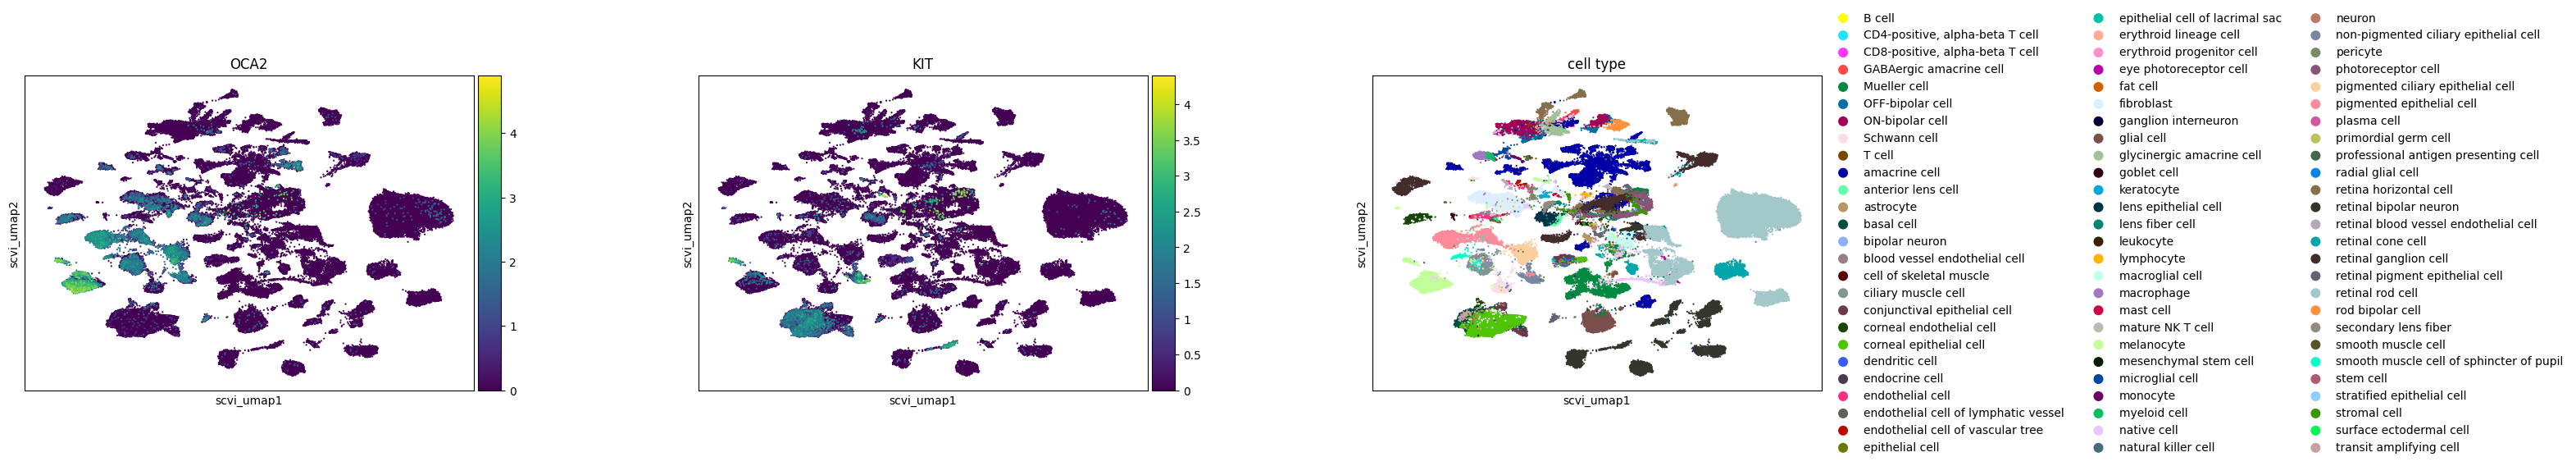

In [4]:
sc.pl.scatter(adata, basis="geneformer_umap", color=["OCA2", "KIT", "cell_type"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scgpt_umap", color=["OCA2", "KIT", "cell_type"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="uce_umap", color=["OCA2", "KIT", "cell_type"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scvi_umap", color=["OCA2", "KIT", "cell_type"], size=10, use_raw=False)

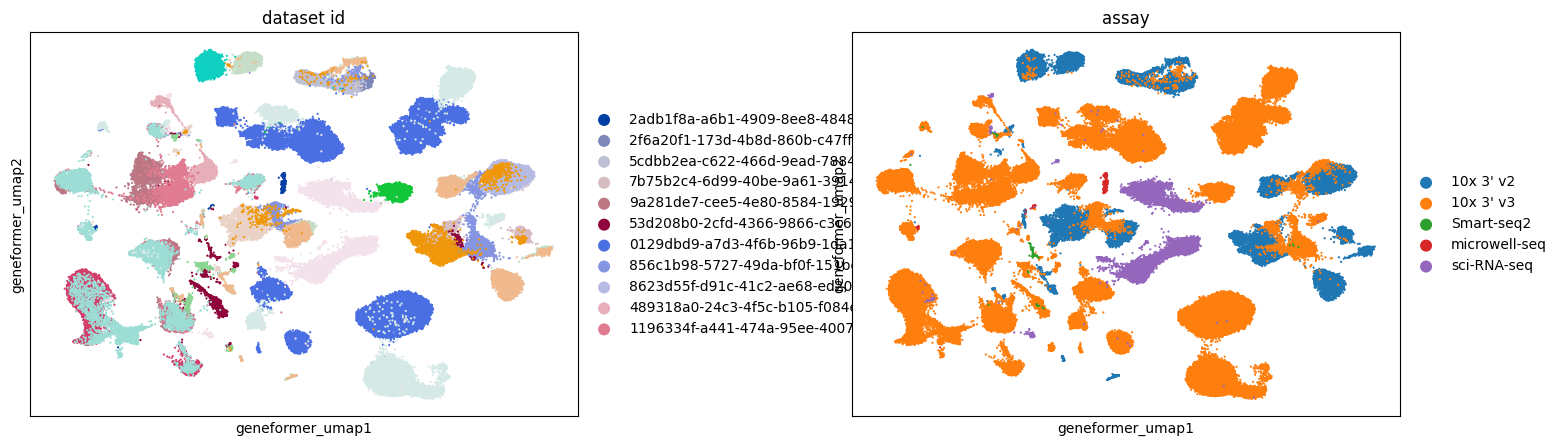

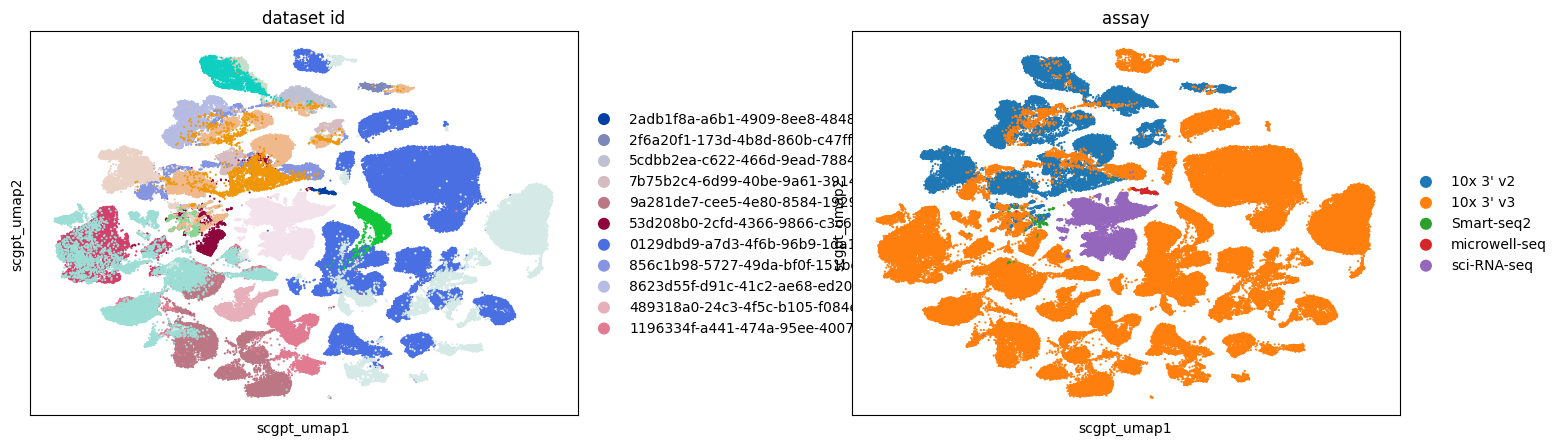

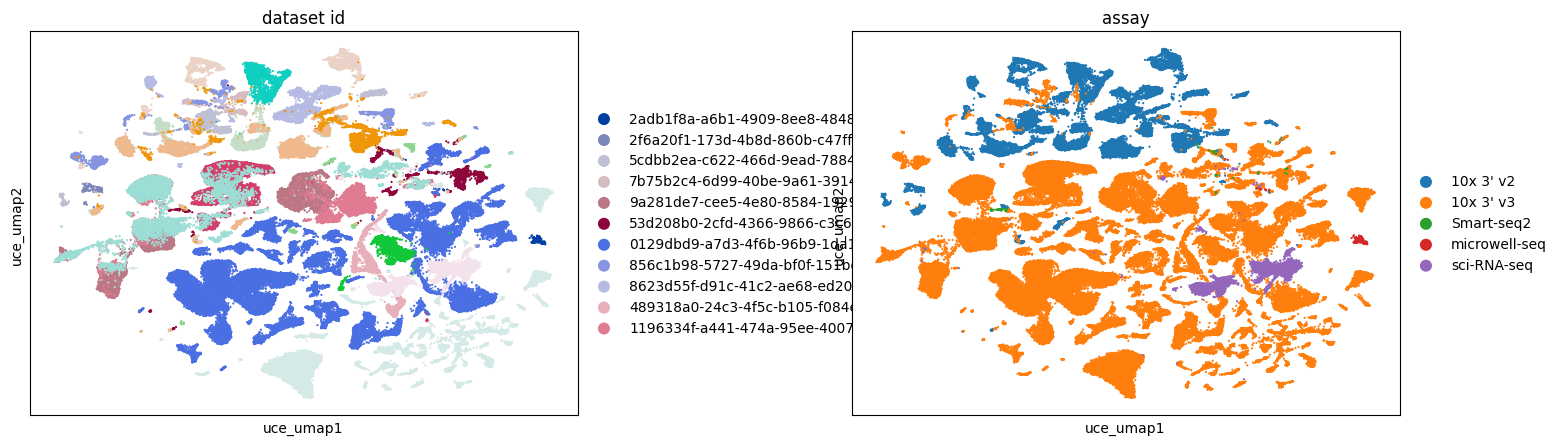

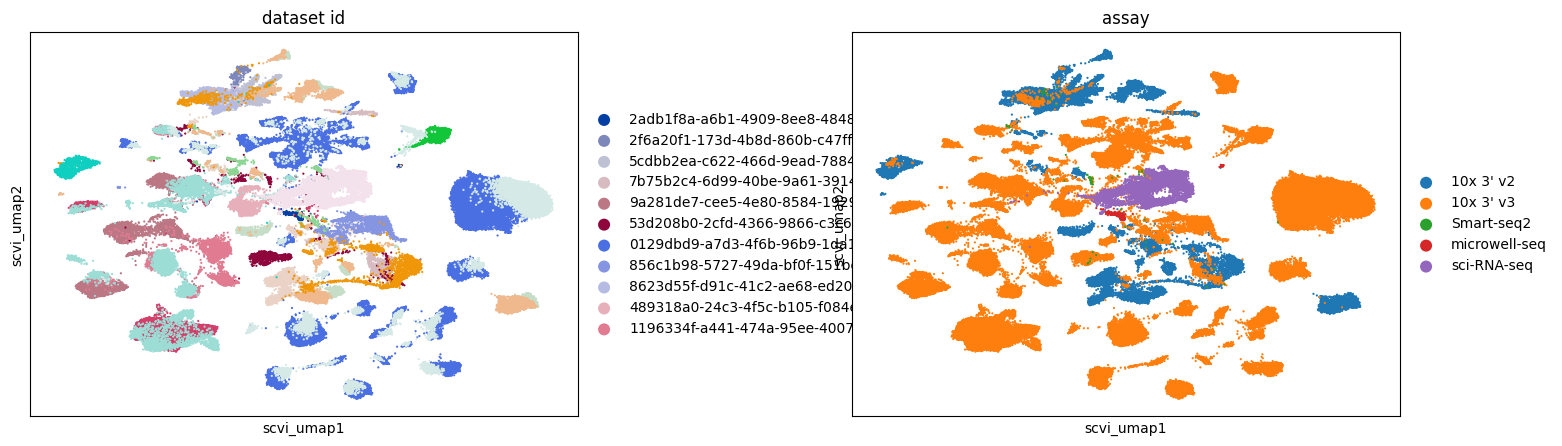

In [5]:
sc.pl.scatter(adata, basis="geneformer_umap", color=["dataset_id", "assay"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scgpt_umap", color=["dataset_id", "assay"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="uce_umap", color=["dataset_id", "assay"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scvi_umap", color=["dataset_id", "assay"], size=10, use_raw=False)

## Retinal bipolar neurons in eye

In a more detailed analysis of retinal bipolar neurons in the eye, we focus on subclustering within this cell type across various embeddings. This involves rerunning UMAP specifically for retinal bipolar neurons and applying Leiden clustering to each embedding. Additionally, we employ [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html), a density-based clustering algorithm, on a full pairwise Euclidean distance matrix calculated from each embedding to compare the clustering results.

Key findings from this analysis include:
 - In the scGPT embedding, the nearest neighbor graph construction reveals 25 distinct clusters, but the density-based HDBSCAN approach identifies only 4 clusters, indicating a significant difference in clustering patterns.
 - The UCE and SCVI embeddings show good agreement between graph-based and density-based clustering methods.
 - For Geneformer, the lsubclusters observed in UMAP appear to be an artifact of the graph construction, as HDBSCAN results in only one primary cluster.

When assessing the Normalized Mutual Information (NMI) score between Leiden and HDBSCAN cluster assignments, it's found that:
 - All embeddings yield Leiden clusters with generally good agreement across methods (NMI > 0.65), indicating a consistent clustering pattern.
 - HDBSCAN clusterings are more method-specific, reflecting inherent differences in how each embedding interprets distances and densities. Geneformer, in particular, shows minimal agreement with other methods as HDBSCAN only identified one main cluster. This is expected as Geneformer was finetuned on a cell subclass prediction task, which will homogenize cells belonging to the same label.
 - Additionally, all methods, except SCVI, distinctly separate retinal bipolar neurons by batch (dataset ID), underscoring the presence of batch effects.

From this analysis, we can draw a couple conclusions:
 - The construction of k-nearest neighbor graphs in embeddings like UMAP can lead to the identification of subclusters that are not evident when examining pairwise distances directly in the original embedding spaces. This suggests that the reliance of UMAP (and many other methods spanning a wide variety of tasks) on k-nearest neighbor graphs may introduce biologically unjustifiable subclusters. This is a known phenomenon and further supports the recommendation to cross-reference findings using fuller representations of the data.
 - In this example, UCE clusters the data much more than other methods. This observation holds true in both graph- and density-based clustering. The small clusters identified in UCE often lack unique or biologically relevant gene expression signatures, necessitating further investigation to understand any biological relevance or lack thereof for each of the identified clusters.

In [ ]:
import hdbscan
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import normalized_mutual_info_score

# subset anndata
adata_rbn = adata[adata.obs["cell_type"] == "retinal bipolar neuron"].copy()

# generate UMAPs
adata_rbn = generate_umaps_from_embeddings(adata_rbn, embedding_names_all)

# run clustering methods
for embedding in embedding_names_all:
    sc.tl.leiden(adata_rbn, obsp=f"{embedding}_connectivities", key_added=f"{embedding}_leiden")

    points = adata_rbn.obsm[embedding]

    # calculate full pairwise distance matrix
    pairwise_dist = squareform(pdist(points, "euclidean"))
    # run HDBSCAN
    adata_rbn.obs[f"{embedding}_hdbscan"] = (
        hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, metric="precomputed")
        .fit_predict(pairwise_dist)
        .astype("int")
        .astype("str")
    )

# display UMAPs and report normalized mutual information scores between leiden and hdbscan cluster assignments
for embedding in embedding_names_all:
    print("Normalized mutual information between Leiden and HDBSCAN clusters:")
    print(normalized_mutual_info_score(adata_rbn.obs[f"{embedding}_leiden"], adata_rbn.obs[f"{embedding}_hdbscan"]))
    sc.pl.scatter(
        adata_rbn,
        basis=f"{embedding}_umap",
        color=[f"{embedding}_leiden", f"{embedding}_hdbscan", "dataset_id"],
        size=10,
        use_raw=False,
    )


# compare leiden and hdbscan cluster assignments across methods and display the similarity tables
embedding_keys = embedding_names_all
sim_scores_leiden = np.zeros((len(embedding_keys), len(embedding_keys)))
sim_scores_hdbscan = np.zeros((len(embedding_keys), len(embedding_keys)))
for i, embedding_i in enumerate(embedding_keys):
    for j, embedding_j in enumerate(embedding_keys):
        sim_scores_leiden[i, j] = normalized_mutual_info_score(
            adata_rbn.obs[f"{embedding_i}_leiden"], adata_rbn.obs[f"{embedding_j}_leiden"]
        )
        sim_scores_hdbscan[i, j] = normalized_mutual_info_score(
            adata_rbn.obs[f"{embedding_i}_hdbscan"], adata_rbn.obs[f"{embedding_j}_hdbscan"]
        )

sim_scores_leiden_table = pd.DataFrame(data=sim_scores_leiden, index=embedding_keys, columns=embedding_keys)
sim_scores_hdbscan_table = pd.DataFrame(data=sim_scores_hdbscan, index=embedding_keys, columns=embedding_keys)

print("Leiden:")
print(sim_scores_leiden_table)
print("")
print("HDBSCAN:")
print(sim_scores_hdbscan_table)

Generating UMAP for geneformer
Generating UMAP for scvi
Generating UMAP for scgpt
Generating UMAP for uce


## Dopaminergic neurons in brain
### Sample and fetch 150k cells from brain tissue

In [ ]:
# Let's find our cells of interest
obs_value_filter = "tissue_general=='brain' and is_primary_data == True"

obs_df = census["census_data"][EXPERIMENT_NAME].obs.read(
    value_filter = obs_value_filter,
    column_names = ["soma_joinid"]
)

obs_df = obs_df.concat().to_pandas() 
print(obs_df.shape[0], "cells in", obs_value_filter)

# Let's subset to 150K
n_subset_cells = 150000
print("Selecting ", n_subset_cells, " random cells")
idx_rand = np.random.choice(obs_df.shape[0], size=n_subset_cells, replace=False)
soma_joinids_subset = obs_df["soma_joinid"].values[idx_rand].tolist()

# Let's get the AnnData
adata = build_anndata_with_embeddings(
    embedding_uris_community, 
    embedding_names_census,
    coords=soma_joinids_subset,
    experiment_name=EXPERIMENT_NAME, 
    census_version=CENSUS_VERSION,
)

adata = generate_umaps_from_embeddings(adata, embedding_names_all)

### Observations
Here, we visualize a randomly selected subset of cells in the brain from CELLxGENE Census. We can observe that dopaminergic neurons, marked by TH expression, separate into distinct clusters in Geneformer and SCVI latent spaces, whereas in UCE and scGPT embeddings, they are grouped at one end of a larger neuron cluster.

All embeddings show a tendency to cluster by assay, indicating a consistent pattern across different models. Conditions like glioblastoma are clearly separated in all embeddings, while pilocytic astrocytoma is distinctly clustered in Geneformer and UCE and more mixed in others.

In the UCE embedding, we observe small satellite clusters within the main glioblastoma cluster that do not have distinct gene expression signatures. This is similar to what we observed previously in the eye (e.g. for the retinal bipolar neurons).

In [ ]:
sc.pl.scatter(adata, basis="geneformer_umap", color=["TH", "assay", "disease"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scgpt_umap", color=["TH", "assay", "disease"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="uce_umap", color=["TH", "assay", "disease"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scvi_umap", color=["TH", "assay", "disease"], size=10, use_raw=False)

## Pulmonary ionocytes in lung (Tabula Sapiens)
### Fetch lung cells from Tabula Sapiens


In [ ]:
obs_value_filter = "tissue_general=='lung' and dataset_id=='53d208b0-2cfd-4366-9866-c3c6114081bc'"

adata = build_anndata_with_embeddings(
    embedding_uris_community, 
    embedding_names_census,
    obs_value_filter=obs_value_filter, 
    experiment_name=EXPERIMENT_NAME, 
    census_version=CENSUS_VERSION
)

adata = generate_umaps_from_embeddings(adata, embedding_names_all)

### Observations
For the case study focusing on pulmonary ionocytes in lung tissue, as part of the Tabula Sapiens project, the following observations are noted:

- In all embeddings, except for SCVI, a clear separation is seen between SmartSeq data and 10x data. The distinction is most pronounced in the scGPT embedding.
- CFTR, a marker for pulmonary ionocytes, identifies a rare cell type in the lung. This cell type is distinctly recognizable in all the embeddings.

In [ ]:
sc.pl.scatter(adata, basis="geneformer_umap", color=["CFTR", "assay", "cell_type"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scgpt_umap", color=["CFTR", "assay", "cell_type"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="uce_umap", color=["CFTR", "assay", "cell_type"], size=10, use_raw=False)
sc.pl.scatter(adata, basis="scvi_umap", color=["CFTR", "assay", "cell_type"], size=10, use_raw=False)

In [ ]:
census.close()